# Ensemble models

gwlearn currently implements geographically weighted versions of ensemble models for the classification tasks. However, there's a caveat. Given it is unlikely that all categories are present in all local models, fitting a non-binary would lead to inconsistent local models. Hence gwlearn currently supports only binary classification.

In [1]:
import geopandas as gpd
from geodatasets import get_path
from sklearn import metrics

from gwlearn.ensemble import GWGradientBoostingClassifier, GWRandomForestClassifier

Get sample data

In [22]:
gdf = gpd.read_file(get_path("geoda.ncovr")).to_crs(5070)

gdf['point'] = gdf.representative_point()
gdf = gdf.set_geometry('point')

y = gdf["FH90"] > gdf["FH90"].median()
X = gdf.iloc[:, 9:15]

## Random Forest

The implementation of geographically-weighted random forest classifier follows the logic of linear models, where each local neighborhood defiend by a set bandwidth is used to fit a single local model. 

In [3]:
gwrf = GWRandomForestClassifier(
    geometry=gdf.geometry,
    bandwidth=250,
    fixed=False,
)
gwrf.fit(
    X,
    y,
)

,bandwidth,250
,fixed,False
,kernel,'bisquare'
,include_focal,False
,geometry,0 PO...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,False
,temp_folder,None


### Focal score

The performance of these models can be measured in three ways. The first one is using the focal prediction. Unlike in linear models, where the focal observation is part of the local model training, in this case it is excluded to ensure it can be used to evaluate the model. Otherwise, it would be a part of the data the local model has seen and would report unrealistically high performance. If you want to include the focal observation in the training nevertheless, just set `include_focal=True`.

Focal accuracy can be measured as follows. Note that some local models are not fitted due to [imbalance rules](imbalance.ipynb), and report NA that needs to be filtered out.

In [8]:
na_mask = gwrf.pred_.notna()

metrics.accuracy_score(y[na_mask], gwrf.pred_[na_mask])

0.7675324675324675

### Pooled out-of-bag score

Another option is to pull the out-of-bag predictions from individual local models and pool them together. This uses more data to evaluate the model but given the local models are tuned for their focal location, some predictions on locations far from the focal point may be artifically worse than the actual model prediction would be.

In [9]:
metrics.accuracy_score(gwrf.oob_y_pooled_, gwrf.oob_pred_pooled_)

0.7641593073593074

### Local score

The final option is to take the local out-of-bag predicitons and measure performance per each local model. To do that, you can use a method `local_metric()`.

In [10]:
local_accuracy = gwrf.local_metric(metrics.accuracy_score)
local_accuracy

array([  nan, 0.832, 0.816, ..., 0.724, 0.68 , 0.84 ], shape=(3085,))

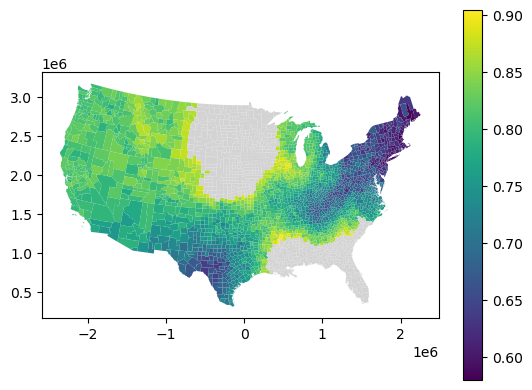

Exception ignored in: <function ResourceTracker.__del__ at 0x1082393a0>
Traceback (most recent call last):
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1032793a0>
Traceback (most recent call last):
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/Users/martin/dev/pysal/gwlearn/.pixi/envs/default/lib/python3.12/m

In [38]:
gdf.set_geometry('geometry').plot(local_accuracy, legend=True, missing_kwds=dict(color='lightgray'));

### Feature importance

Feature importances are reported for each local model.

In [24]:
gwrf.feature_importances_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.163537,0.126297,0.129279,0.168100,0.195099,0.217688
2,0.145373,0.144598,0.129570,0.170864,0.212494,0.197102
3,0.159493,0.153623,0.121976,0.157709,0.188459,0.218739
4,0.139064,0.138513,0.132356,0.165172,0.169107,0.255788
...,...,...,...,...,...,...
3080,0.133556,0.098009,0.194193,0.103091,0.304674,0.166477
3081,0.160259,0.100542,0.166279,0.206054,0.200703,0.166163
3082,0.150734,0.187798,0.182689,0.260491,0.088495,0.129792
3083,0.155197,0.178728,0.197449,0.259757,0.098295,0.110574


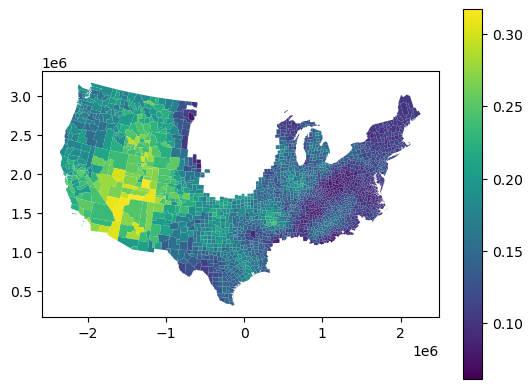

In [37]:
gdf.set_geometry('geometry').plot(gwrf.feature_importances_["HC60"], legend=True);

You can compare all of this to values extracted from a global model, fitted alongside.

In [26]:
gwrf.global_model.feature_importances_

array([0.13291293, 0.13947853, 0.19458703, 0.20237261, 0.16271606,
       0.16793284])

In [27]:
gwrf.feature_importances_.mean()

HR60    0.142955
HR70    0.156098
HR80    0.189825
HR90    0.191385
HC60    0.146325
HC70    0.173411
dtype: float64

## Gradient boosting

If you prefer to use gradient boosting, there is a minimal implementation of geographically weighted gradient boosting classifier, following the same model described for the random forest above.

In [28]:
gwgb = GWGradientBoostingClassifier(
    geometry=gdf.geometry,
    bandwidth=250,
    fixed=False,
)
gwgb.fit(
    X,
    y,
)

,bandwidth,250
,fixed,False
,kernel,'bisquare'
,include_focal,False
,geometry,0 PO...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,False
,temp_folder,None


Given the nature of the model, the outputs are a bit more limited. You can still extract focal predictions.

In [29]:
nan_mask = gwgb.pred_.notna()

metrics.accuracy_score(y[nan_mask], gwgb.pred_[nan_mask])

0.7453362255965292

And local feature importances.

In [30]:
gwgb.feature_importances_

,HR60,HR70,HR80,HR90,HC60,HC70
0,NaN,NaN,NaN,NaN,NaN,NaN
1,0.171780,0.122330,0.068557,0.160250,0.134976,0.342105
2,0.181095,0.125482,0.062881,0.162664,0.123770,0.344107
3,0.144945,0.141568,0.077769,0.167760,0.070632,0.397326
4,0.166898,0.134353,0.072315,0.157555,0.111711,0.357169
...,...,...,...,...,...,...
3080,0.099964,0.060816,0.146350,0.039145,0.591701,0.062024
3081,0.083627,0.078908,0.129297,0.226416,0.446836,0.034917
3082,0.105542,0.194637,0.174340,0.334278,0.060160,0.131043
3083,0.133985,0.163022,0.160660,0.363089,0.052984,0.126260


### Leave out samples

However, the pooled data are not available. In this case, you can use the `leave_out` keyword to leave out a fraction (when float) or a set number (when int) of random observations from each local model. For these, the local model does prediction and returns as `left_out_proba_` and `left_out_y_` arrays.

In [32]:
gwgb_leave = GWGradientBoostingClassifier(
    geometry=gdf.geometry,
    bandwidth=250,
    fixed=False,
    leave_out=.2
)
gwgb_leave.fit(
    X,
    y,
)

,bandwidth,250
,fixed,False
,kernel,'bisquare'
,include_focal,False
,geometry,0 PO...type: geometry
,graph,None
,n_jobs,-1
,fit_global_model,True
,strict,False
,keep_models,False
,temp_folder,None


In [36]:
metrics.accuracy_score(gwgb_leave.left_out_y_, gwgb_leave.left_out_proba_.argmax(axis=1))

0.7486247288503254